<a href="https://colab.research.google.com/github/ThiagoMilanezPinheiro/MachineLearning-SGBF/blob/main/2_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lithology Prediction Using Well Logs: 2016 SEG Tutorial and Contest

In 2016 *The Leading Edge*, a magazine of Society of Exploration Geophysics ([SEG](https://seg.org/)), published a [tutorial on machine learning](https://library.seg.org/doi/full/10.1190/tle35100906.1) by Brendon Hall. The tutorial was followed by an [open contest](https://github.com/seg/2016-ml-contest), organized by Matt Hall, where the participants were invited to improve the results.

The tutorial is available on [SEG Wiki](https://wiki.seg.org/wiki/Facies_classification_using_machine_learning) and [GitHub](https://github.com/seg/tutorials-2016/tree/master/1610_Facies_classification).

We will use the data from this contest to discuss the problem of *classification*. Classification and regression are the two basic kinds of problems addressed by *supervised* machine learning.

## Examining the dataset

Let us first download the data and set the problem. The data were originally provided by Kansas Geological Survey from the [joint project with industry partners](http://www.kgs.ku.edu/HAMP/) on analyzing the Permian gas systems of the Hugoton and Panoma Fields in southwest Kansas and Oklahoma Panhandle.

![](https://ars.els-cdn.com/content/image/1-s2.0-S0098300406001956-gr1.jpg)

* Dubois, M.K., Bohling, G.C. and Chakrabarti, S., 2007. [Comparison of four approaches to a rock facies classification problem](https://doi.org/10.1016/j.cageo.2006.08.011). *Computers & Geosciences*, 33(5), pp.599-617.

*The Hugoton field, which is only one of the numerous gas and oil fields in the Hugoton area, is the largest gas field in North America and one of the largest gas fields in the world. It is nearly 12,000 square miles in size and contains over 11,000 producing gas and oil wells. Since 1928, the gas fields of southwestern Kansas, including Hugoton, Panoma, Bradshaw, and Byerly, have produced over 26 trillion cubic feet of gas. Hugoton production is a major source of gas and oil for the state of Kansas and the nation.*
http://www.kgs.ku.edu/PRS/publication/ofr2001-33/P1-03.html

In [ ]:
import pandas as pd

# load data from CSV file
url = 'https://raw.githubusercontent.com/seg/2016-ml-contest/master/facies_vectors.csv'
data = pd.read_csv(url)
data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [ ]:
# data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     4149 non-null   int64  
 1   Formation  4149 non-null   object 
 2   Well Name  4149 non-null   object 
 3   Depth      4149 non-null   float64
 4   GR         4149 non-null   float64
 5   ILD_log10  4149 non-null   float64
 6   DeltaPHI   4149 non-null   float64
 7   PHIND      4149 non-null   float64
 8   PE         3232 non-null   float64
 9   NM_M       4149 non-null   int64  
 10  RELPOS     4149 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 356.7+ KB


There are three important differences from the previous case we studied.

1. There are multiple wells, identified by name.

In [ ]:
wellnames = data['Well Name'].unique()
print(wellnames)

['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A'
 'CROSS H CATTLE' 'NOLAN' 'Recruit F9' 'NEWBY' 'CHURCHMAN BIBLE']


Measurements are sampled at a half-foot interval along each well.

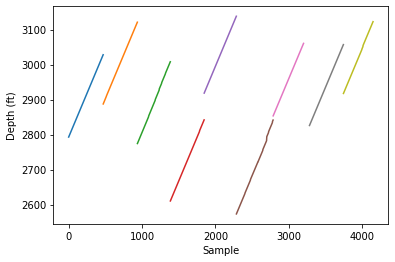

In [ ]:
import matplotlib.pyplot as plt

for name in wellnames:
    if name != 'Recruit F9': # Recruit F9 is a pseudo-well
        depth = data[data['Well Name']==name].loc[:,'Depth']
        plt.plot(depth)
plt.xlabel('Sample')
plt.ylabel('Depth (ft)')
plt.show()

2. There are five measurements coming from well logs.

| Key | Description | 
|-----|-------------|
| **GR** | gamma ray | 
| **ILD_log10** | resistivity  | 
| **DeltaPHI**  | neutron-density porosity difference |
| **PHIND** | average neutron-density porosity | 
| **PE**  | photoelectric effect | 

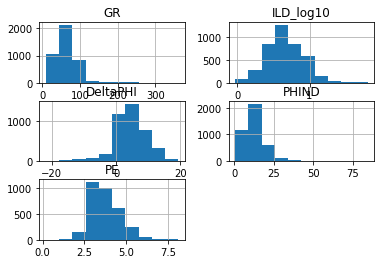

In [ ]:
logs = data.loc[:,['GR','ILD_log10','DeltaPHI','PHIND','PE']]
hist = logs.hist()

In [ ]:
logs.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE
count,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000
mean,64.933985,0.659566,4.402484,13.201066,3.725014
std,30.302530,0.252703,5.274947,7.132846,0.896152
min,10.149000,-0.025949,-21.832000,0.550000,0.200000
25%,44.730000,0.498000,1.600000,8.500000,3.100000
50%,64.990000,0.639000,4.300000,12.020000,3.551500
75%,79.438000,0.822000,7.500000,16.050000,4.300000
max,361.150000,1.800000,19.312000,84.400000,8.094000


Looking at the **count** attribute, notice that it is smaller for **PE** than for other logs. It turns out that **PE** log is not available for some of the wells from the dataset.

3. Additionally, there are geologic indicators.

| Key | Indicator | 
|-----|-------------|
| **Facies** | lithofacies code | 
| **Formation** | formation name  | 
| **NM_M**  | non-marine–marine |
| **RELPOS** | relative position | 

The non-marine–marine indicator identifies a depositional environment and was assigned according to the stratigraphic formations. Relative position identifies the position of a particular sample with respect to the base of its respective non-marine or marine formation interval.

Lithofacies are identified from continuous core analysis.

|Code |Label| Color | Facies Name | Adjacent | 
|-----|-----|:-------:|:-------------|----------|
|1 | SS | <span style="color:#F4D03F">yellow</span> | Nonmarine sandstone | 2 | 
|2 |CSiS| <span style="color:#F5B041">light orange</span> | Nonmarine coarse siltstone | 1,3 |
|3 |FSiS| <span style="color:#DC7633">orange</span> | Nonmarine fine siltstone  | 2 |
|4 |SiSh| <span style="color:#6E2C00">brown</span> | Marine siltstone and shale | 5 |
|5 |MS| <span style="color:#1B4F72">dark blue</span> | Mudstone (limestone) | 4,6 |
|6 |WS| <span style="color:#2E86C1">blue</span> | Wackestone (limestone) | 5,7 |
|7 |D| <span style="color:#AED6F1">light blue</span> | Dolomite | 6,8 |
|8 |PS| <span style="color:#A569BD">purple</span> | Packstone-grainstone (limestone) | 6,7,9 |
|9 |BS| <span style="color:#196F3D">green</span> | Phylloid-algal bafflestone (limestone) | 7,8 |

In [ ]:
facies_codes=['SS','CSiS','FSiS','SiSh','MS','WS','D','PS','BS']

import matplotlib.colors as colors

facies_colors=['#F4D03F','#F5B041','#DC7633','#6E2C00',
               '#1B4F72','#2E86C1','#AED6F1','#A569BD','#196F3D']
cmap = colors.ListedColormap(facies_colors)

For convenience, let us define a function for plotting data for individual wells.

In [ ]:
import numpy as np
from mpl_toolkits import axes_grid1 

lognames = ['GR','ILD_log10','DeltaPHI','PHIND','PE']
logcolors = 'gbcrk' # green,blue,cyan,red,black

def plot_well(name,pred=[]):
    'plot data values for one well'
    
    well = data.loc[data['Well Name']==name].copy()
    nlogs = len(lognames)
    if len(pred) > 0:
        # add prediction column
        well.loc[:,'Prediction']=pred
        ncols = nlogs+2
    else:
        ncols = nlogs+1
    well = well.sort_values(by='Depth')
    # extract depth
    depth = well.Depth
    zmin=depth.min()
    zmax=depth.max()
    
    f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(8, 12))
    
    # plot logs in a loop
    for log in range(nlogs):
        axl = ax[log]
        index = lognames[log]
        color = logcolors[log] 
        # plot as curve
        axl.plot(well[index],depth,'-'+color)
        axl.grid()
        # set depth axis
        axl.set_ylim(zmax,zmin)
        if log == 0:
            axl.set_ylabel('Depth (ft)')
        else:
            axl.set_yticklabels([])
        # set horizontal axis
        axl.set_xlabel(index)
        axl.locator_params(axis='x',nbins=3)
        
    # plot facies
    for col in range(nlogs,ncols):
        axf = ax[col]
        index = ['Facies','Prediction'][col-5]
        # create matrix
        facies=np.expand_dims(well[index],1)
        # plot as image  
        im=axf.imshow(facies,interpolation='none',
                      aspect='auto',cmap=cmap,vmin=1,vmax=9)
        # set depth axis
        axf.set_yticklabels([])
        # set horizontal axis
        axf.set_xlabel(index)
        axf.set_xticks([])
        axf.set_yticks([])
    
    # add colorbar: same size as plot
    divider = axes_grid1.make_axes_locatable(axf)
    cax = divider.append_axes('right',size='20%',pad=0.05)
    cbar=plt.colorbar(im,cax=cax)
    cbar.set_label((18*' ').join(facies_codes))
    cbar.set_ticks([])
    
    # add plot title
    f.suptitle('Well: ' + name,fontsize=14,y=0.92)

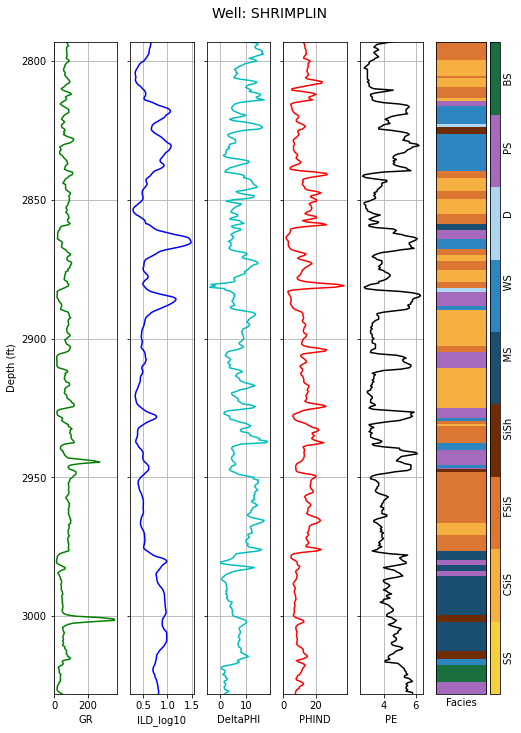

In [ ]:
plot_well('SHRIMPLIN')

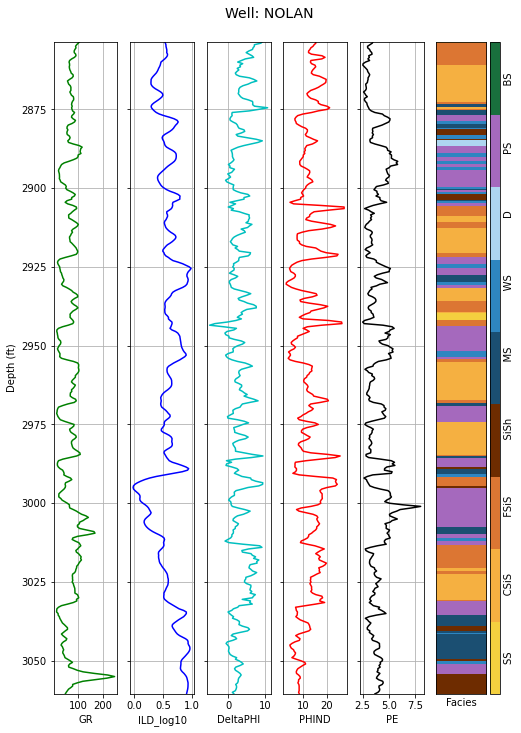

In [ ]:
plot_well('NOLAN')

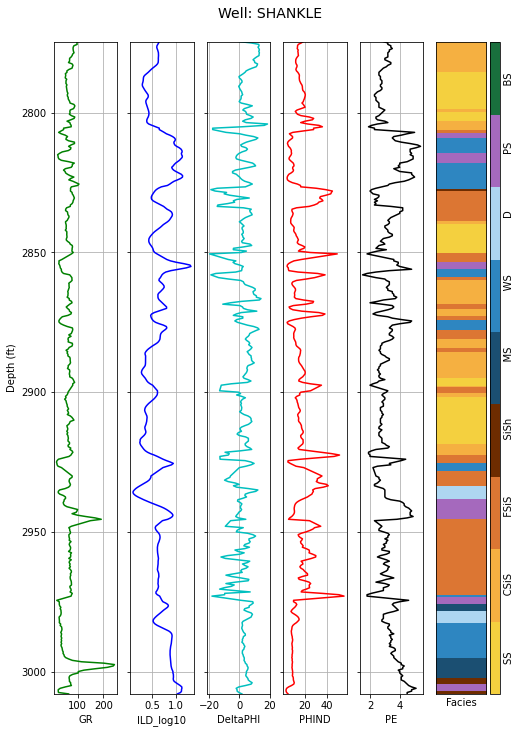

In [ ]:
plot_well('SHANKLE')

## Objective

Our objective is to build a statistical model for predicting lithofacies from well-log measurements and geologic indicators (NM_M and RELPOS). A model like that could help extend geologic information from the training data to nearby wells that have well-log measurements but lack continuous core analysis.

Because the dependent variable refers to a category and not to a continuous value, this is a *classification* problem.

Following the contest rules, we will remove the well named SHANKLE to use it for blind testing.

In [ ]:
shankle = data['Well Name'] == 'SHANKLE' 

data_shankle = data[shankle]
data_train = data[~shankle]

data_train.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3700.000000,3700.000000,3700.000000,3700.000000,3700.000000,3700.000000,2783.000000,3700.000000,3700.000000
mean,4.615676,2908.853378,64.873649,0.663053,4.651677,12.892826,3.805693,1.540000,0.524125
std,2.475808,139.010855,30.817166,0.253863,5.109006,6.796219,0.894118,0.498465,0.287147
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2818.500000,43.778250,0.502000,1.800000,8.350000,3.200000,1.000000,0.278000
50%,4.000000,2939.000000,64.817000,0.645613,4.400000,11.857500,3.600000,2.000000,0.531000
75%,7.000000,3015.125000,80.322500,0.823000,7.600000,15.750000,4.400000,2.000000,0.772000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


## First try: two logs and k-NN classifier

As a first try, let us take only two logs (gamma-ray and resistivity) to observe how they map into the desired categories.

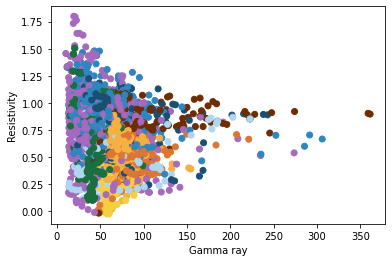

In [ ]:
colors=[facies_colors[f-1] for f in data.Facies]
plt.scatter(data.GR,data.ILD_log10,c=colors)
plt.xlabel('Gamma ray')
plt.ylabel('Resistivity')
plt.show()

Not all facies easily separate into clusters in the 2-D plot but some clustering does occur. 

We can predict the facies of each point by looking at its closest neighbors. This method of classification is known as the *nearest-neighbor* algorithm.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/279px-KnnClassification.svg.png)

https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

The number of nearest neighbors (K) used for voting on a class is a critical parameter.

Let us give it a try. Because we will be computing the distance function, it is important to normalize the variables. Normalization scales them to unitless measures with zero mean and unit variance.

$$\widehat{\mathbf{x}} = \displaystyle \frac{\mathbf{x}-\mu}{\sigma}\;,$$

where

$$\mu = \displaystyle \frac{1}{N} \sum_{n=1}^{N} x_n$$

and

$$\sigma = \displaystyle \sqrt{\frac{1}{N} \sum_{n=1}^{N} (x_n-\mu)^2}\;.$$

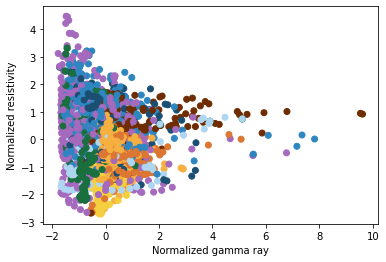

In [ ]:
from sklearn import preprocessing

# select two logs
x2 = data_train.loc[:,['GR','ILD_log10']]
# scale to zero mean and unit variance
scaler = preprocessing.StandardScaler()
x2 = scaler.fit(x2).transform(x2)
y2 = data_train.Facies

# plot to check
colors=[facies_colors[f-1] for f in y2]
plt.scatter(x2[:,0],x2[:,1],c=colors)
plt.xlabel('Normalized gamma ray')
plt.ylabel('Normalized resistivity')
plt.show()

In [ ]:
preprocessing.StandardScaler?

In [ ]:
np.std?

As we did in the regression example, let us separate the dataset into two parts for training and validation. A convenient function for that is **train_test_split**. 

In [ ]:
from sklearn.model_selection import train_test_split

x2_train, x2_test,  \
y2_train, y2_test = \
    train_test_split(x2,y2,test_size=0.2,random_state=2021)

print('Training: ',x2_train.shape,y2_train.shape)
print('Testing: ',x2_test.shape,y2_test.shape)

Training:  (2960, 2) (2960,)
Testing:  (740, 2) (740,)


The data are split randomly according to **test_size=**, the **random_state=** parameter assures reproducibility.

Now we are ready to launch the classifier.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# define classifier by setting k
cls2 = KNeighborsClassifier(n_neighbors=3)
# train the classifier
cls2.fit(x2_train,y2_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Effectively, our classifier is going to divide the space of dependent variables into regions corresponding to different facies.

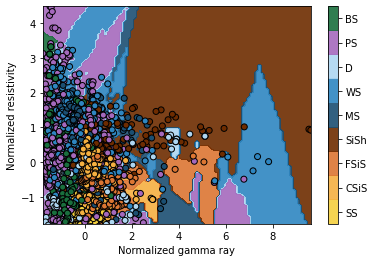

In [ ]:
def plot_regions(cls):
    'plot regions in 2-D space as defined by classifier'
    
    # create 100 x 100 grid
    G = np.linspace(x2[:,0].min(),x2[:,0].max(),100)
    R = np.linspace(x2[:,0].min(),x2[:,1].max(),100)
    G,R = np.meshgrid(G,R)
    # predict facies for every point
    grid = np.array([G.ravel(),R.ravel()]).T
    F = cls.predict(grid).reshape(G.shape)

    # overlay map and scatter plot
    cf = plt.contourf(G,R,F,np.arange(0.5,10.5),cmap=cmap,alpha=0.9)
    plt.scatter(x2[:,0],x2[:,1],c=colors,edgecolors='k')
    plt.axis([G.min(),G.max(),R.min(),R.max()])
    cbar = plt.colorbar(cf,ticks=range(1,10))
    cbar.ax.set_yticklabels(facies_codes) 
    plt.xlabel('Normalized gamma ray')
    plt.ylabel('Normalized resistivity')
    plt.show()
    
plot_regions(cls2)

In [ ]:
# make prediction
y2_pred = cls2.predict(x2_test)

### Evaluating results

How accurate is our prediction? We can assign it a score.

In [ ]:
from sklearn.metrics import accuracy_score

print('Testing accuracy: %.3f' % accuracy_score(y2_test,y2_pred))

y2_pred = cls2.predict(x2_train)
print('Training accuracy: %.3f' % accuracy_score(y2_train,y2_pred))

Testing accuracy: 0.385
Training accuracy: 0.649


A more informative output is the *confusion matrix*.

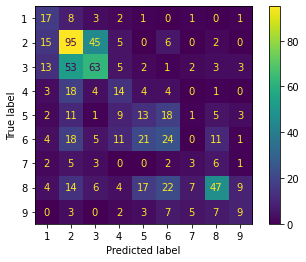

In [ ]:
from sklearn.metrics import plot_confusion_matrix

cm = plot_confusion_matrix(cls2,x2_test,y2_test)

The confusion matrix is a table that shows how many times the classifier was correct or incorrect in identifying a particular class. The ideal matrix should be diagonal.

![](https://devopedia.org/images/article/208/6541.1566280388.jpg)

https://devopedia.org/confusion-matrix


For each "label" (facies in our case), the prediction results fall into one of the four categories: TN (true negative), TP (true positive), FN (false negative), and FP (false positive). The **accuracy_score** metric in <code>sklearn</code> is [Jaccard score](https://en.wikipedia.org/wiki/Jaccard_index) defined as

$$J = \displaystyle \frac{\mbox{TP}}{\mbox{TP} + \mbox{FP} + \mbox{FN}}\;,$$

averaged over all labels. It takes values between 0 and 1.

In [ ]:
accuracy_score?

In [ ]:
from sklearn.metrics import jaccard_score

jaccard_score?

### Tuning parameters

How can we improve the result? Let us try a different value of k (the number of nearest neighbors).

Testing accuracy: 0.431


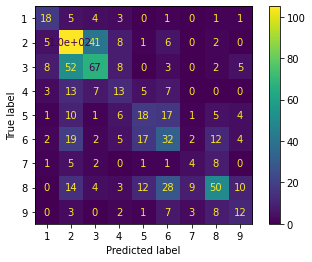

In [ ]:
cls2 = KNeighborsClassifier(n_neighbors=5)
# train the classifier
cls2.fit(x2_train,y2_train)
# make prediction
y2_pred = cls2.predict(x2_test)
# compute score
print('Testing accuracy: %.3f' % accuracy_score(y2_test,y2_pred))
# plot confusion matrix
cm = plot_confusion_matrix(cls2,x2_test,y2_test)

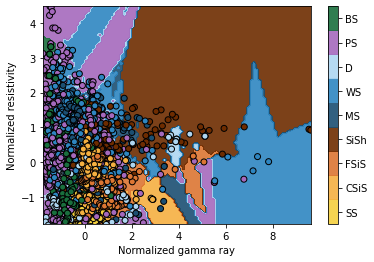

In [ ]:
plot_regions(cls2)

## <span style="color:red">Task 1</span>

The classifier used in the TLE tutorial is based on the SVM (Support Vector Machine) algorithm. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/247px-SVM_margin.png)

https://en.wikipedia.org/wiki/Support-vector_machine

The initial idea of this algorithm is based on searching for a hyperplane  that would provide the best separation between points of two classes. The problem amounts to minimization

$$\displaystyle \min_{\mathbf{w},b} \left[\frac{1}{N}\sum_{n=1}^N \max\left(0, 1 - y_n(\mathbf{w}^T \mathbf{x}_n - b)\right) \right] + \lambda \|\mathbf{w}\|^2\;,$$

where $\mathbf{x}_n$ are independent variables, $y_n$ is the labeled variable, $\lambda$ is the regularization parameter, and $\mathbf{w}$ and $b$ are the estimated parameters. The idea was extended to multiple classification labels and to areas separated by curves rather than planes.

The SVM classifier is provided in <code>sklearn.svm.SVC</code>. Some of its key parameters are:

| Parameter | Meaning |
|----------------|:---------|
| **C** | regularization parameter ($\lambda$ in the equation above) |
| **kernel** | mapping for handling non-linear boundaries (use **kernel='linear'** for the original formulation) |

**Your task**: try the SVM classifier (<code>SVC</code>) instead of the nearest-neighbor classifier on the two-log problem and output the accuracy score, the confusion matrix, and a plot of the classification regions in the 2-D space.

In [ ]:
from sklearn.svm import SVC

SVC?

## Use all data

For consistency, we will remove wells that don't have **PE** logs.

In [ ]:
has_pe = ~data_train['PE'].isna()
data_train_pe = data_train[has_pe]
data_train_pe.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000
mean,4.558390,2873.456522,66.249445,0.644637,3.754963,13.118929,3.805693,1.523895,0.523057
std,2.515249,138.349383,31.610849,0.241922,5.045916,7.389665,0.894118,0.499518,0.287499
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2767.500000,46.081500,0.497000,1.300000,8.165000,3.200000,1.000000,0.276500
50%,4.000000,2895.000000,65.541000,0.627000,3.581000,11.900000,3.600000,2.000000,0.529000
75%,7.000000,2987.000000,80.714000,0.812323,6.500000,16.144000,4.400000,2.000000,0.771500
max,9.000000,3122.500000,361.150000,1.480000,18.500000,84.400000,8.094000,2.000000,1.000000


Next, we select dependent and independent variables and apply normalization.

In [ ]:
y = data_train_pe.Facies
x = data_train_pe.drop(columns=['Facies','Formation','Well Name'])

In [ ]:
# split into training and testing
x_train, x_test, y_train, y_test = \
    train_test_split(x,y,test_size=0.2,random_state=2021)

print('Training: ',x_train.shape,y_train.shape)
print('Testing: ',x_test.shape,y_test.shape)

Training:  (2226, 8) (2226,)
Testing:  (557, 8) (557,)


In [ ]:
# scale to zero mean and unit variance
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
# define classifier by setting k
cls = KNeighborsClassifier(n_neighbors=3)
# train the classifier
cls.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Testing accuracy: 0.752


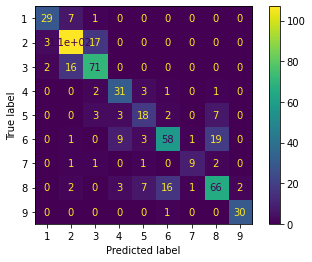

In [ ]:
# make prediction
y_pred = cls.predict(x_test)
# compute score
print('Testing accuracy: %.3f' % accuracy_score(y_test,y_pred))
# plot confusion matrix
cm = plot_confusion_matrix(cls,x_test,y_test)

## <span style="color:red">Task 2</span>

In the two-log problem, we saw that the number of neighbors was a critical parameter for the nearest-neighbor classification algorithm. 

**Your task**: try changing this parameter in the multivariable case and make a plot or a table of the testing accuracy versus the number of neighbors.

## Blind test

Recall that we set one well aside to use it for blind testing. Now is the time to bring it back and test our classifier.

In [ ]:
y_shankle = data_shankle.Facies
x_shankle = data_shankle.drop(columns=['Facies','Formation','Well Name'])
x_shankle = scaler.transform(x_shankle)

Testing accuracy: 0.430


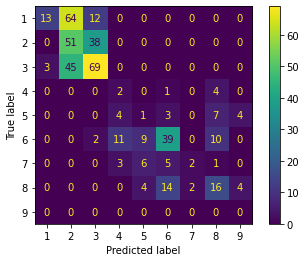

In [ ]:
# make prediction
y_pred = cls.predict(x_shankle)
# compute score
print('Testing accuracy: %.3f' % accuracy_score(y_shankle,y_pred))
# plot confusion matrix
cm = plot_confusion_matrix(cls,x_shankle,y_shankle)

We can plot our prediction to compare it visually with the true values.

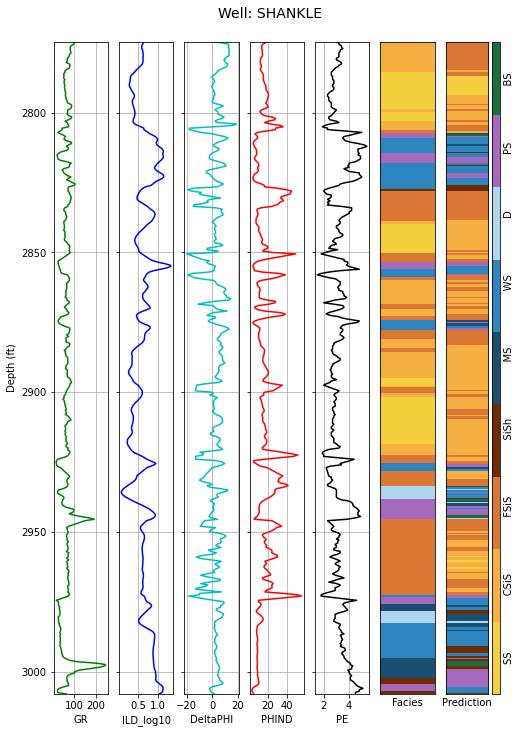

In [ ]:
plot_well('SHANKLE',y_pred)

## <span style="color:red">Bonus Tasks</span>

1. Find out which wells do not have **PE** (photoelectric effect) logs.

*The log measures the photoelectric absorption factor, $P_e$, which is defined as $(Z/10)^{3.6}$ where $Z$ is the average atomic number of the formation. $P_e$ is unitless, but since it is proportional to the photoelectric cross section per electron, it is sometimes quoted in barns/electron. Since fluids have very low atomic numbers, they have very little influence, so that $P_e$ is a measure of the rock matrix properties. Sandstones have low $P_e$, while dolomites and limestones have high $P_e$. Clays, heavy minerals and iron-bearing minerals have high $P_e$. Thus, the log is very useful for determining mineralogy.*
https://www.glossary.oilfield.slb.com/en/terms/p/pef

![](https://petrowiki.spe.org/images/f/f7/Vol5_Page_0267_Image_0001.png)
https://petrowiki.spe.org/Density_logging#Photoelectric_.28PE.29_absorption

2. Instead of dropping wells without **PE** logs, use all the wells in the training dataset and drop **PE** logs from them. Does it improve the results?

3. Use either statistical or geological arguments to reduce the number of predicted categories by combining some of the labels. Does it improve the results?

## Apply the classification model to new data

Now that we have found some way of predicting lithofacies, we can apply it to nearby wells that have well-logs but lack continuous core analysis.

In [ ]:
url = 'https://raw.githubusercontent.com/seg/2016-ml-contest/master/validation_data_nofacies.csv'
newdata = pd.read_csv(url)
newdata.head()

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911


In [ ]:
newdata.describe()

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,830.000000,830.00000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,2987.070482,57.61173,0.666312,2.851964,11.655277,3.654178,1.678313,0.535807
std,94.391925,27.52774,0.288367,3.442074,5.190236,0.649793,0.467405,0.283062
min,2808.000000,12.03600,-0.468000,-8.900000,1.855000,2.113000,1.000000,0.013000
25%,2911.625000,36.77325,0.541000,0.411250,7.700000,3.171500,1.000000,0.300000
50%,2993.750000,58.34450,0.675000,2.397500,10.950000,3.515500,2.000000,0.547500
75%,3055.375000,73.05150,0.850750,4.600000,14.793750,4.191500,2.000000,0.778000
max,3160.500000,220.41300,1.507000,16.500000,31.335000,6.321000,2.000000,1.000000


In [ ]:
wellnames = newdata['Well Name'].unique()
print(wellnames)

['STUART' 'CRAWFORD']


In [ ]:
newx = newdata.drop(columns=['Formation','Well Name'])
# scale to zero mean and unit variance
newx = scaler.transform(newx)

In [ ]:
# make prediction
facies = cls.predict(newx)
newdata.loc[:,'Facies'] = facies[:]

In [ ]:
data = pd.concat([data,newdata])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4979 entries, 0 to 829
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     4979 non-null   int64  
 1   Formation  4979 non-null   object 
 2   Well Name  4979 non-null   object 
 3   Depth      4979 non-null   float64
 4   GR         4979 non-null   float64
 5   ILD_log10  4979 non-null   float64
 6   DeltaPHI   4979 non-null   float64
 7   PHIND      4979 non-null   float64
 8   PE         4062 non-null   float64
 9   NM_M       4979 non-null   int64  
 10  RELPOS     4979 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 466.8+ KB


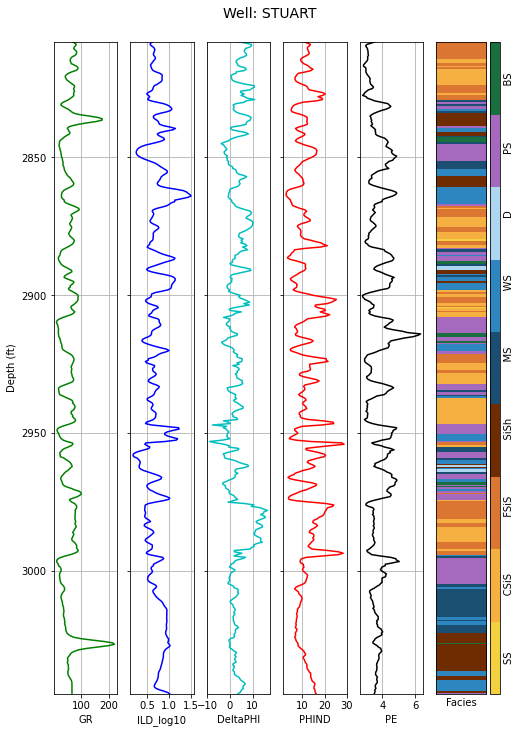

In [ ]:
plot_well('STUART')

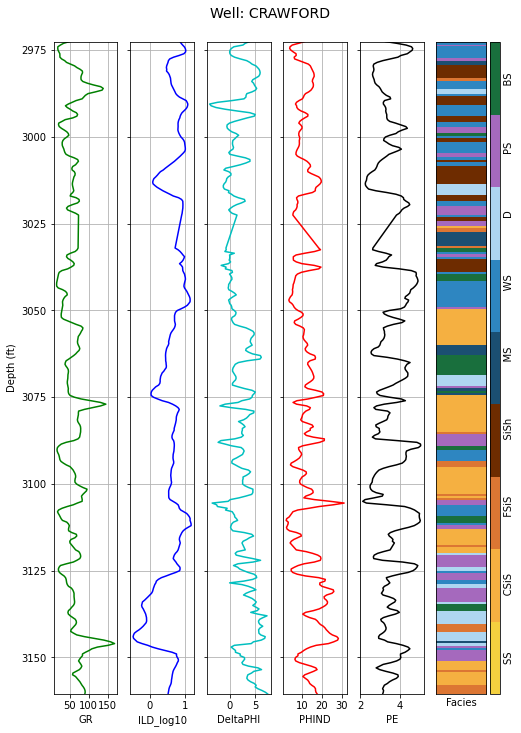

In [ ]:
plot_well('CRAWFORD')

## References

Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem, *Computers & Geosciences*, 33 (5), 599-617. [doi:10.1016/j.cageo.2006.08.011](https://doi.org/10.1016/j.cageo.2006.08.011)

Hall, B., 2016, Facies classification using machine learning, *The Leading Edge*, 35(10), 906-909. [doi:10.1190/tle35100906.1](https://doi.org/10.1190/tle35100906.1)

Hall, M. and Hall, B., 2017, Distributed collaborative prediction: Results of the machine learning contest, *The Leading Edge*, 36(3), 267-269. [doi:10.1190/tle36030267.1](https://doi.org/10.1190/tle36030267.1)